In [26]:
from vedo import embedWindow
embedWindow(None)

from brainrender import Scene
import brainrender
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
os.getcwd()
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name="ternary_centered"):
    """
    Function to offset the “center” of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap’s dynamic range to be at zero
    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap’s range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap’s range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0."""
    cdict = {
        "red": [],
        "green": [],
        "blue": [],
        "alpha": []
    }
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)
    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(start, midpoint, 128, endpoint=False),
        np.linspace(midpoint, stop, 129, endpoint=True)
    ])
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)
        cdict["red"].append((si, r, r))
        cdict["green"].append((si, g, g))
        cdict["blue"].append((si, b, b))
        cdict["alpha"].append((si, a, a))
    newcmap = colors.LinearSegmentedColormap(name, cdict)
    return newcmap

## Plotting figure 1

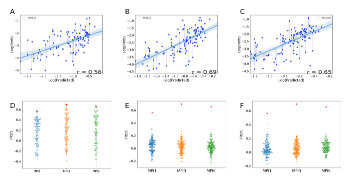

In [83]:
from pylab import *
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt

timepoint=[1,3,6]
image=[]
for tp in timepoint:
    Cor = Image.open("../Data_ReScience/iCPu/Predicted_VS_Path_MPI{}_iCPu.png".format(tp))
    image.append(Cor)

rnd_seed = Image.open("../Data_ReScience/iCPu/Random_Seed.png")
rnd_patho = Image.open("../Data_ReScience/iCPu/Random_Patho_iCPu.png")
rnd_adj = Image.open("../Data_ReScience/iCPu/Random_Adja_iCPu.png")

fig= plt.figure()
G = gridspec.GridSpec(nrows=6, ncols=6)
plt.tight_layout()
V = gridspec.GridSpec(nrows=6, ncols=6)
plt.tight_layout()

axes_1 = fig.add_subplot(G[0:4, 0:2])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.annotate("A",(50,150), fontsize=7, color="black")
plt.annotate("r = 0.56",(1475,1400), fontsize=6, color="black")
plt.imshow(image[0])

axes_2 = fig.add_subplot(G[0:4,2:4])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.annotate("B",(50,150), fontsize=7, color="black")
plt.annotate("r = 0.69",(1475,1400), fontsize=6, color="black")
plt.imshow(image[1])

axes_3 = fig.add_subplot(G[0:4, 4:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.annotate("C",(50,150), fontsize=7, color="black")
plt.annotate("r = 0.65",(1475,1400), fontsize=6, color="black")
plt.imshow(image[2])

axes_4 = fig.add_subplot(V[3:7,0:2])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.annotate("D",(50,150), fontsize=7, color="black")
plt.imshow(rnd_seed)

axes_5 = fig.add_subplot(V[3:7,2:4])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.annotate("E",(50,150), fontsize=7, color="black")
plt.imshow(rnd_patho)


axes_6 = fig.add_subplot(V[3:7,4:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.annotate("F",(50,150), fontsize=7, color="black")
plt.imshow(rnd_adj)


plt.savefig('../Data_ReScience/iCPu/Fig2.png', dpi=300)
plt.savefig('../Data_ReScience/iCPu/Fig2.pdf', dpi=300)
plt.show()

## Plotting Figure 3

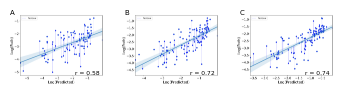

In [35]:
from pylab import *
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt

timepoint=[1,3,6]
image=[]
for tp in timepoint:
    Cor = Image.open("../Data_ReScience/SNCA/Predicted_VS_Path_MPI{}_iCPu_SNCA.png".format(tp))
    image.append(Cor)
    
fig = plt.figure()
G = gridspec.GridSpec(nrows=3, ncols=6)

axes_1 = fig.add_subplot(G[0:4, 0:2])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.annotate("A",(50,150), fontsize=7, color="black")
plt.annotate("r = 0.58",(1400,1400), fontsize=6, color="black")
plt.imshow(image[0])

axes_2 = fig.add_subplot(G[0:4, 2:4])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.annotate("B",(50,150), fontsize=7, color="black")
plt.annotate("r = 0.72",(1400,1400), fontsize=6, color="black")
plt.imshow(image[1])

axes_3 = fig.add_subplot(G[0:4, 4:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.annotate("C",(50,150), fontsize=7, color="black")
plt.annotate("r = 0.74",(1400,1400), fontsize=6, color="black")
plt.imshow(image[2])

plt.savefig('../Data_ReScience/SNCA/Fig4.png', dpi=300)
plt.savefig('../Data_ReScience/SNCA/Fig4.pdf', dpi=300)
plt.show()

## Plotting Figure 4

##     a) Piriform

In [28]:
from vedo import embedWindow
embedWindow(None)

from brainrender import Scene
import brainrender
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

cmap= plt.get_cmap("Reds")
data_pir = pd.read_csv('../output/predicted_pathology_iPir.csv')
reg_names = pd.read_excel('./Data83018/BrainR_ROInames.xlsx')

data_pir.head()

# Matching with BrainRender
for r in data_pir.index:
    
    names = reg_names[reg_names['ROInames'] == data_pir.loc[r, 'regions']]['BrainR']
    
    if len(names) > 1:
         data_pir.loc[r, 'br_regions'] = list(names)[0]
    elif len(names) == 1:    
        data_pir.loc[r, 'br_regions'] = names.values
        
for r in data_pir.index:
    
    if data_pir.loc[r, 'regions'][0] == 'i':
        data_pir.loc[r, 'hem'] = 'right'
    elif data_pir.loc[r, 'regions'][0] == 'c':
        data_pir.loc[r, 'hem'] = 'left' 
        
# No midpoint required ==> COntinous cmap
max_Pir= np.max(data_pir['MPI6'])
min_Pir = np.min(data_pir['MPI1'])

#Normalisation
data_pir['MPI6'] = (data_pir['MPI6'] - min_Pir) / (max_Pir - min_Pir)
data_pir['MPI3'] = (data_pir['MPI3'] - min_Pir) / (max_Pir - min_Pir)
data_pir['MPI1'] = (data_pir['MPI1'] - min_Pir) / (max_Pir - min_Pir)
data_pir = data_pir.dropna()

data_pir.head()

from brainrender import Scene, atlas
from tqdm import tqdm

list_coor = [-2100, -1080, +1360, +2820, +4500] # Bregma corresponding coordinates

timepoints = [1,3,6]

for t in tqdm(timepoints):
    
    for section in list_coor:
        bregma = np.array([5400,  # AP    
              0,  # DV    
              5700,]) # ML

        bregma[0] = bregma[0] + section

        # Create a brainrender scene
        scene = Scene(inset=False,screenshots_folder="../Screenshot_Brainrender/PIR_MPIs")
        frontal_camera = {
             'pos': (-19781, 3777, -5832),
             'viewup': (0, -1, 0),
             'clippingRange': (24465, 26836),
            'focalPoint': (5705, 3991, -5691),
             'distance': 25487}

        # Add brain regions
        for r in data_pir.index:

            region_to_plot = data_pir.loc[r, "br_regions"]
            color = cmap(100*data_pir.loc[r, 'MPI{}'.format(t)])[:3]
            alpha =  cmap(data_pir.loc[r, 'MPI{}'.format(t)])[:3]
            scene.add_brain_region(region_to_plot, color=color, alpha=1, hemisphere=data_pir.loc[r, 'hem'], silhouette=True) #alpha=data_cpu.loc[r, 'MPI{}'.format(t)]
        
        #scene.add_brain_region("PIR", color="blue", alpha=1, hemisphere='right', silhouette=True)


        plane_1 = scene.atlas.get_plane(pos=bregma+50, plane="frontal", norm=(-1, 0, 0), alpha=1, color="white") # Thickness: 150 um
        plane_2 = scene.atlas.get_plane(pos=bregma-50, plane="frontal", norm=(1, 0, 0), alpha=1, color="white")
        scene.slice(plane_1, close_actors=True)
        scene.slice(plane_2, close_actors=True)


        brainrender.settings.SHADER_STYLE = "cartoon" #[metallic, plastic, shiny, glossy]
        brainrender.settings.ROOT_ALPHA = 0.17
        brainrender.settings.LW =2.4
        brainrender.settings.ROOT_COLOR  = [0.5019, 0.5019, 0.5019]
        brainrender.settings.OFFSCREEN = True
        brainrender.settings.SHOW_AXES = False
        brainrender.settings.BACKGROUND_COLOR = "white"
        scene.render(atlas_name='allen_mouse_50um', camera= frontal_camera, zoom=1.5)
        scene.screenshot(name="50um_Pir_MPI{}_Breg_{}_mm".format(t,-section/1000), scale = 3)
        scene.close()

  0%|          | 0/3 [00:00<?, ?it/s]

Saving new screenshot at 50um_Pir_MPI1_Breg_2.1_mm.png

Saving new screenshot at 50um_Pir_MPI1_Breg_1.08_mm.png

Saving new screenshot at 50um_Pir_MPI1_Breg_- 1. 36_mm.png

Saving new screenshot at 50um_Pir_MPI1_Breg_- 2. 82_mm.png

Saving new screenshot at 50um_Pir_MPI1_Breg_- 4. 5_mm.png

 33%|███▎      | 1/3 [01:20<02:40, 80.17s/it]

Saving new screenshot at 50um_Pir_MPI3_Breg_2.1_mm.png

Saving new screenshot at 50um_Pir_MPI3_Breg_1.08_mm.png

Saving new screenshot at 50um_Pir_MPI3_Breg_- 1. 36_mm.png

Saving new screenshot at 50um_Pir_MPI3_Breg_- 2. 82_mm.png

Saving new screenshot at 50um_Pir_MPI3_Breg_- 4. 5_mm.png

 67%|██████▋   | 2/3 [02:40<01:20, 80.09s/it]

Saving new screenshot at 50um_Pir_MPI6_Breg_2.1_mm.png

Saving new screenshot at 50um_Pir_MPI6_Breg_1.08_mm.png

Saving new screenshot at 50um_Pir_MPI6_Breg_- 1. 36_mm.png

Saving new screenshot at 50um_Pir_MPI6_Breg_- 2. 82_mm.png

Saving new screenshot at 50um_Pir_MPI6_Breg_- 4. 5_mm.png

100%|██████████| 3/3 [03:58<00:00, 79.56s/it]


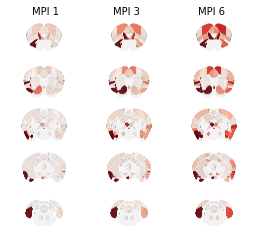

In [30]:
from pylab import *
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt

list_coor = [-2100, -1080, +1360, +2820, +4500] # Bregma corresponding coordinates
timepoint=[1,3,6]
image=[]
for tp in timepoint:
    for section in list_coor:
        Cor = Image.open("../Screenshot_Brainrender\PIR_MPIs/50um_Pir_MPI{}_Breg_{}_mm.png".format(tp,-section/1000))
        image.append(Cor)
        
fig = plt.figure()
G = gridspec.GridSpec(nrows=15, ncols=12, wspace=0.2)


axes_1_1 = fig.add_subplot(G[0:3, 0:3])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.text(3250,-100,"MPI 1", ha="right")
# plt.annotate("A",(50,150), fontsize=7, color="black")
plt.imshow(image[0])

axes_2_1 = fig.add_subplot(G[3:6, 0:3])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[1])

axes_3_1 = fig.add_subplot(G[6:9, 0:3])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[2])

axes_4_1 = fig.add_subplot(G[9:12, 0:3])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[3])

axes_5_1 = fig.add_subplot(G[12:15, 0:3])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[4])


###############


axes_1_3 = fig.add_subplot(G[0:3, 3:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.text(3000,-100,"MPI 3", ha="right")
# plt.annotate("A",(50,150), fontsize=7, color="black")
plt.imshow(image[5])

axes_2_3 = fig.add_subplot(G[3:6, 3:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[6])

axes_3_3 = fig.add_subplot(G[6:9, 3:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[7])

axes_4_3 = fig.add_subplot(G[9:12, 3:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[8])

axes_5_3 = fig.add_subplot(G[12:15, 3:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[9])


###############

axes_1_6 = fig.add_subplot(G[0:3, 6:9])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.text(3000,-100,"MPI 6", ha="right")
# plt.annotate("A",(50,150), fontsize=7, color="black")
plt.imshow(image[10])

axes_2_6 = fig.add_subplot(G[3:6, 6:9])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[11])

axes_3_6 = fig.add_subplot(G[6:9, 6:9])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[12])

axes_4_6 = fig.add_subplot(G[9:12, 6:9])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[13])

axes_5_6 = fig.add_subplot(G[12:15, 6:9])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[14])

plt.savefig('../Data_ReScience/Pir SN/Pir.png', dpi=300)
plt.savefig('../Data_ReScience/Pir SN/Pir.pdf', dpi=300)
plt.show()

## b) SN

In [29]:
from vedo import embedWindow
embedWindow(None)
from tqdm import tqdm
from brainrender import Scene
import brainrender
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

cmap = plt.get_cmap('Reds')

data_sn = pd.read_csv('../output/predicted_pathology_iSN.csv')
reg_names = pd.read_excel('./Data83018/BrainR_ROInames.xlsx')

data_sn.head()

# Matching with BrainRender
for r in data_sn.index:
    
    names = reg_names[reg_names['ROInames'] == data_sn.loc[r, 'regions']]['BrainR']
    
    if len(names) > 1:
         data_sn.loc[r, 'br_regions'] = list(names)[0]
    elif len(names) == 1:    
        data_sn.loc[r, 'br_regions'] = names.values
        
for r in data_sn.index:
    
    if data_sn.loc[r, 'regions'][0] == 'i':
        data_sn.loc[r, 'hem'] = 'right'
    elif data_sn.loc[r, 'regions'][0] == 'c':
        data_sn.loc[r, 'hem'] = 'left' 
        
# Normalization using Max and Min - Seed Pir
max_SN= np.max(data_sn['MPI6'])
min_SN = np.min(data_sn['MPI1'])

data_sn['MPI6'] = (data_sn['MPI6'] - min_SN) / (max_SN - min_SN)
data_sn['MPI3'] = (data_sn['MPI3'] - min_SN) / (max_SN - min_SN)
data_sn['MPI1'] = (data_sn['MPI1'] - min_SN) / (max_SN - min_SN)
data_sn = data_sn.dropna()

data_sn.head()
#list_coor = [-1700, 0, +2700, +3000, +4040] # Bregma corresponding coordinates
list_coor = [-2100, -1080, +1360, +2820, +4500] # Bregma corresponding coordinates

timepoints = [1,3,6]
for t in tqdm(timepoints):
    
    for section in list_coor:
        bregma = np.array([5400,  # AP    
              0,  # DV    
              5700,]) # ML

        bregma[0] = bregma[0] + section

        # Create a brainrender scene
        scene = Scene(inset=False,screenshots_folder="../Screenshot_Brainrender/SN_MPIs")
        frontal_camera = {
             'pos': (-19781, 3777, -5832),
             'viewup': (0, -1, 0),
             'clippingRange': (25465, 26836),
            'focalPoint': (5705, 3991, -5691),
             'distance': 25487}

        # Add brain regions
        for r in data_sn.index:

            region_to_plot = data_sn.loc[r, "br_regions"]
            color = cmap(data_sn.loc[r, 'MPI{}'.format(t)])[:3]
            alpha =  cmap(data_sn.loc[r, 'MPI{}'.format(t)])[:3]
            scene.add_brain_region(region_to_plot, color=color, alpha=1, hemisphere=data_sn.loc[r, 'hem'], silhouette=True) #alpha=data_cpu.loc[r, 'MPI{}'.format(t)]


        plane_1 = scene.atlas.get_plane(pos=bregma+50, plane="frontal", norm=(-1, 0, 0), alpha=1, color="white") # Thickness: 150 um
        plane_2 = scene.atlas.get_plane(pos=bregma-50, plane="frontal", norm=(1, 0, 0), alpha=1, color="white")
        scene.slice(plane_1, close_actors=True)
        scene.slice(plane_2, close_actors=True)


        brainrender.settings.SHADER_STYLE = "cartoon" #[metallic, plastic, shiny, glossy]
        brainrender.settings.ROOT_ALPHA = 0.17
        brainrender.settings.LW =2.4
        brainrender.settings.ROOT_COLOR  = [0.4, 0.4, 0.4]
        brainrender.settings.OFFSCREEN = True
        brainrender.settings.SHOW_AXES = False
        brainrender.settings.BACKGROUND_COLOR = "white"
        scene.render(atlas_name='allen_mouse_50um', camera= frontal_camera, zoom=1.5)
        scene.screenshot(name="50um_SNc_MPI{}_Breg_{}_mm".format(t,section/1000), scale = 3)
        img_totranspose = Image.open("../Screenshot_Brainrender\SN_MPIs/50um_SNc_MPI{}_Breg_{}_mm.png".format(t,section/1000))
        img_totranspose = img_totranspose.transpose(Image.FLIP_LEFT_RIGHT)
        img_totranspose.save("../Screenshot_Brainrender\SN_MPIs/50um_SNc_MPI{}_Breg_{}_mm.png".format(t,section/1000))
#         title="-Coronal section Bregma {} mm -50um thickness- Seed = SN - MPI {}".format(-section/1000,t),
        scene.close()

  0%|          | 0/3 [00:00<?, ?it/s]

Saving new screenshot at 50um_SNc_MPI1_Breg_- 2. 1_mm.png

Saving new screenshot at 50um_SNc_MPI1_Breg_- 1. 08_mm.png

Saving new screenshot at 50um_SNc_MPI1_Breg_1.36_mm.png

Saving new screenshot at 50um_SNc_MPI1_Breg_2.82_mm.png

Saving new screenshot at 50um_SNc_MPI1_Breg_4.5_mm.png

 33%|███▎      | 1/3 [01:25<02:50, 85.33s/it]

Saving new screenshot at 50um_SNc_MPI3_Breg_- 2. 1_mm.png

Saving new screenshot at 50um_SNc_MPI3_Breg_- 1. 08_mm.png

Saving new screenshot at 50um_SNc_MPI3_Breg_1.36_mm.png

Saving new screenshot at 50um_SNc_MPI3_Breg_2.82_mm.png

Saving new screenshot at 50um_SNc_MPI3_Breg_4.5_mm.png

 67%|██████▋   | 2/3 [02:54<01:26, 86.47s/it]

Saving new screenshot at 50um_SNc_MPI6_Breg_- 2. 1_mm.png

Saving new screenshot at 50um_SNc_MPI6_Breg_- 1. 08_mm.png

Saving new screenshot at 50um_SNc_MPI6_Breg_1.36_mm.png

Saving new screenshot at 50um_SNc_MPI6_Breg_2.82_mm.png

Saving new screenshot at 50um_SNc_MPI6_Breg_4.5_mm.png

100%|██████████| 3/3 [04:19<00:00, 86.51s/it]


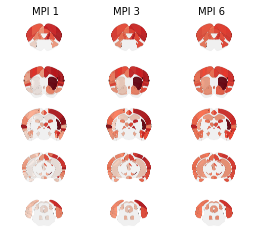

In [31]:
from pylab import *
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt

list_coor = [-2100, -1080, +1360, +2820, +4500] # Bregma corresponding coordinates
timepoint=[1,3,6]
image=[]
for tp in timepoint:
    for section in list_coor:
        Cor = Image.open("../Screenshot_Brainrender/SN_MPIs/50um_SNc_MPI{}_Breg_{}_mm.png".format(tp,section/1000))
        image.append(Cor)
        
fig = plt.figure()

G = gridspec.GridSpec(nrows=15, ncols=12, wspace=0.2)


axes_1_1 = fig.add_subplot(G[0:3, 0:3])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.text(3250,-100,"MPI 1", ha="right")
# plt.annotate("A",(50,150), fontsize=7, color="black")
plt.imshow(image[0])

axes_2_1 = fig.add_subplot(G[3:6, 0:3])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[1])

axes_3_1 = fig.add_subplot(G[6:9, 0:3])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[2])

axes_4_1 = fig.add_subplot(G[9:12, 0:3])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[3])

axes_5_1 = fig.add_subplot(G[12:15, 0:3])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[4])


###############


axes_1_3 = fig.add_subplot(G[0:3, 3:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.text(3000,-100,"MPI 3", ha="right")
# plt.annotate("A",(50,150), fontsize=7, color="black")
plt.imshow(image[5])

axes_2_3 = fig.add_subplot(G[3:6, 3:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[6])

axes_3_3 = fig.add_subplot(G[6:9, 3:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[7])

axes_4_3 = fig.add_subplot(G[9:12, 3:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[8])

axes_5_3 = fig.add_subplot(G[12:15, 3:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[9])


###############

axes_1_6 = fig.add_subplot(G[0:3, 6:9])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.text(3000,-100,"MPI 6", ha="right")
# plt.annotate("A",(50,150), fontsize=7, color="black")
plt.imshow(image[10])

axes_2_6 = fig.add_subplot(G[3:6, 6:9])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[11])

axes_3_6 = fig.add_subplot(G[6:9, 6:9])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[12])

axes_4_6 = fig.add_subplot(G[9:12, 6:9])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[13])

axes_5_6 = fig.add_subplot(G[12:15, 6:9])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[14])

plt.savefig('../Data_ReScience/Pir SN/SN.png', dpi=300)
plt.savefig('../Data_ReScience/Pir SN/SN.pdf', dpi=300)
plt.show()

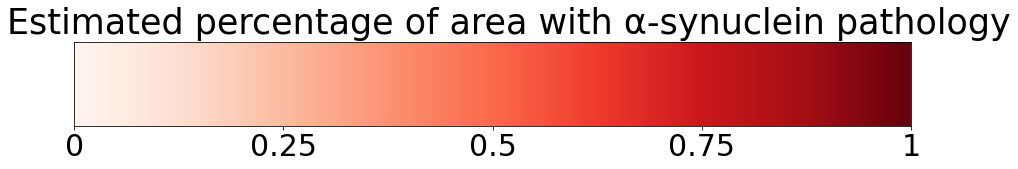

In [27]:
from matplotlib.colors import LinearSegmentedColormap

cmap = plt.get_cmap('Reds')

def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
        
    return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)
    

def view_colormap(cmap):
    """Plot a colormap with its grayscale equivalent"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    cmap = grayscale_cmap(cmap)
    grayscale = cmap(np.arange(cmap.N))
    plt.figure(figsize=(15,3))
    plt.imshow([colors], extent=[0, 10, 0, 1])
    plt.xticks([0, 2.5, 5, 7.5 ,10], ['0', '0.25', '0.5','0.75','1'], fontsize=30)
    plt.yticks([])
    plt.text(-0.8,1.1,'Estimated percentage of area with \u03B1-synuclein pathology', fontsize=35)
    #plt.text(10.5,0.6,'Estimated percentage of area with \u03B1-synuclein')
    plt.savefig("../Screenshot_Brainrender\SN_MPIs/colormap.png",dpi=300)
    plt.savefig("../Screenshot_Brainrender\SN_MPIs/colormap.pdf",dpi=300)
    plt.savefig("../Screenshot_Brainrender\PIR_MPIs/colormap.png",dpi=300)
    plt.savefig("../Screenshot_Brainrender\PIR_MPIs/colormap.pdf",dpi=300)
      
view_colormap("Reds")

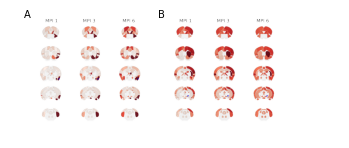

In [66]:
Pir = Image.open('../Data_ReScience/Pir SN/Pir.png')
SN = Image.open("../Data_ReScience/Pir SN/SN.png")
colormap = Image.open("../Screenshot_Brainrender/SN_MPIs/colormap.png")
                      
fig = plt.figure()
G = gridspec.GridSpec(nrows=20, ncols=20, wspace=0.000001, hspace=1)              
axes_1_1 = fig.add_subplot(G[0:20, 0:12])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
#plt.text(795,0,"Piriform In Silico injection", ha="center", fontsize=7)
plt.annotate("A",(150,100), fontsize=10, color="black")
plt.annotate("*",(455,653), fontsize=4, color="blue")
plt.annotate("*",(807,653), fontsize=4, color="blue")
plt.annotate("*",(1159,653), fontsize=4, color="blue")

plt.imshow(Pir)

axes_1_2 = fig.add_subplot(G[0:20, 8:20])
xticks([]), yticks([])
#plt.text(710,0,"SN In Silico injection", ha="center", fontsize=7)
plt.annotate("B",(150,100), fontsize=10, color="black")
plt.annotate("*",(412,810), fontsize=4, color="blue")
plt.annotate("*",(764,810), fontsize=4, color="blue")
plt.annotate("*",(1118,810), fontsize=4, color="blue")



#plt.annotate("B",(150,1050), fontsize=7, color="black")
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
#plt.text(3250,-100,"MPI 1", ha="right")
# plt.annotate("A",(50,150), fontsize=7, color="black")
plt.imshow(SN)

plt.savefig('../Data_ReScience/Pir SN/Fig5_A_B.png', dpi=600)
plt.savefig('../Data_ReScience/Pir SN/Fig5_A_B.pdf', dpi=600)
plt.show()

In [ ]:
axes_1_3 = fig.add_subplot(G[6:7, 4:7])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(colormap)

plt.savefig('../Data_ReScience/Pir SN/Fig5.png', dpi=600)
plt.savefig('../Data_ReScience/Pir SN/Fig5.pdf', dpi=600)

## Plotting Figure 2

## a) Vulnerability

In [43]:
from pylab import *
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

resi_cpu = pd.read_csv('../output/model_output_MPI1_iCPu.csv')
reg_names = pd.read_excel('./Data83018/BrainR_ROInames.xlsx')
resi_cpu.head()
resi_cpu = resi_cpu.rename(columns={'Unnamed: 0': 'region'})

cmap = plt.get_cmap('bwr')
for r in resi_cpu.index:
    
    names = reg_names[reg_names['ROInames'] == resi_cpu.loc[r, 'region']]['BrainR']
    
    if len(names) > 1:
         resi_cpu.loc[r, 'br_regions'] = list(names)[0]
    elif len(names) == 1:    
        resi_cpu.loc[r, 'br_regions'] = names.values
        
for r in resi_cpu.index:
    
    if resi_cpu.loc[r, 'region'][0] == 'i':
        resi_cpu.loc[r, 'hem'] = 'right'
    elif resi_cpu.loc[r, 'region'][0] == 'c':
        resi_cpu.loc[r, 'hem'] = 'left' 
        
resi_cpu.head()
max_resi_cpu = np.max(resi_cpu['residual'])
min_resi_cpu = np.min(resi_cpu['residual'])

resi_cpu['residual']= (resi_cpu['residual']- min_resi_cpu)/(max_resi_cpu-min_resi_cpu)
resi_cpu['residual']
resi_cpu= resi_cpu.dropna() #Dropping the br_regions overlapping in brain render
resi_cpu.to_excel('saved_file.xlsx')
print(max_resi_cpu)
print(min_resi_cpu)

1.4137969796097591
-1.9738798137405544


In [44]:
from vedo import embedWindow
embedWindow(None)

from brainrender import Scene
import brainrender
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pylab import *
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from tqdm import tqdm

resi_cpu = pd.read_csv('../output/model_output_MPI1_iCPu.csv')
reg_names = pd.read_excel('./Data83018/BrainR_ROInames.xlsx')
resi_cpu.head()
resi_cpu = resi_cpu.rename(columns={'Unnamed: 0': 'region'})

for r in resi_cpu.index:
    
    names = reg_names[reg_names['ROInames'] == resi_cpu.loc[r, 'region']]['BrainR']
    
    if len(names) > 1:
         resi_cpu.loc[r, 'br_regions'] = list(names)[0]
    elif len(names) == 1:    
        resi_cpu.loc[r, 'br_regions'] = names.values
        
for r in resi_cpu.index:
    
    if resi_cpu.loc[r, 'region'][0] == 'i':
        resi_cpu.loc[r, 'hem'] = 'right'
    elif resi_cpu.loc[r, 'region'][0] == 'c':
        resi_cpu.loc[r, 'hem'] = 'left' 
        

max_resi_cpu = np.max(resi_cpu['residual'])
min_resi_cpu = np.min(resi_cpu['residual'])
mid_pt= 1 - (max_resi_cpu) / (max_resi_cpu + np.abs(min_resi_cpu))
print(mid_pt)
cmap=shiftedColorMap(cmap=plt.get_cmap("bwr"), start=0.0, midpoint=mid_pt, stop=1.0, name="ternary_centered")


resi_cpu['residual']= (resi_cpu['residual']- min_resi_cpu)/(max_resi_cpu-min_resi_cpu)
resi_cpu['residual']
resi_cpu= resi_cpu.dropna() #Dropping the br_regions overlapping in brain render

list_coor = [-2100, -1080, +1360, +2820, +4500] # Bregma corresponding coordinates
timepoints = [1,3,6]
for section in tqdm(list_coor):
    bregma = np.array([5400,  # AP    
          0,  # DV    
          5700,]) # ML

    bregma[0] = bregma[0] + section

    # Create a brainrender scene
    scene = Scene(inset=False,screenshots_folder="../Screenshot_Brainrender/residuals")
    frontal_camera = {
         'pos': (-19781, 3777, -5832),
         'viewup': (0, -1, 0),
         'clippingRange': (26465, 26836),
        'focalPoint': (5705, 3991, -5691),
         'distance': 25487}

   # Add brain regions
    for r in resi_cpu.index:

        region_to_plot = resi_cpu.loc[r, "br_regions"]
        color = cmap(resi_cpu.loc[r, 'residual'])[:3]

        scene.add_brain_region(region_to_plot, color=color, alpha=1, hemisphere=resi_cpu.loc[r, 'hem'], silhouette=True) #alpha=data_cpu.loc[r, 'MPI{}'.format(t)]


    plane_1 = scene.atlas.get_plane(pos=bregma+50, plane="frontal", norm=(-1, 0, 0), alpha=1, color="white") # Thickness: 150 um
    plane_2 = scene.atlas.get_plane(pos=bregma-50, plane="frontal", norm=(1, 0, 0), alpha=1, color="white")
    plane_3 = scene.atlas.get_plane(plane="sagittal", norm=(0,0,-1), alpha=1, color="white")
    scene.slice(plane_1, close_actors=True)
    scene.slice(plane_2, close_actors=True)
    scene.slice(plane_3, close_actors=True)


    brainrender.settings.SHADER_STYLE = "cartoon" #[metallic, plastic, shiny, glossy]
    brainrender.settings.ROOT_ALPHA = 0.17
    brainrender.settings.LW =2.4
    brainrender.settings.ROOT_COLOR  = [0.4, 0.4, 0.4]
    brainrender.settings.OFFSCREEN = True
    brainrender.settings.SHOW_AXES = False
    brainrender.settings.BACKGROUND_COLOR = "white"
    scene.render(atlas_name='allen_mouse_50um', camera= frontal_camera, zoom=1.5)
    scene.screenshot(name="50um_SNc_MPI1_Breg_{}_mm".format(-section/1000), scale = 3)
    img_totranspose = Image.open("../Screenshot_Brainrender/residuals/50um_SNc_MPI1_Breg_{}_mm.png".format(-section/1000))
    img_totranspose = img_totranspose.transpose(Image.FLIP_LEFT_RIGHT)
    img_totranspose.save("../Screenshot_Brainrender/residuals/50um_SNc_MPI1_Breg_{}_mm.png".format(-section/1000))
    #title="-Coronal section Bregma {} mm -50um thickness- Seed = SN - MPI {}".format(-section/1000,t),
    scene.close()

0.5826647387422237


  0%|          | 0/5 [00:00<?, ?it/s]

Saving new screenshot at 50um_SNc_MPI1_Breg_2.1_mm.png

 20%|██        | 1/5 [00:15<01:03, 15.93s/it]

Saving new screenshot at 50um_SNc_MPI1_Breg_1.08_mm.png

 40%|████      | 2/5 [00:31<00:47, 15.89s/it]

Saving new screenshot at 50um_SNc_MPI1_Breg_- 1. 36_mm.png

 60%|██████    | 3/5 [00:47<00:31, 15.94s/it]

Saving new screenshot at 50um_SNc_MPI1_Breg_- 2. 82_mm.png

 80%|████████  | 4/5 [01:04<00:16, 16.32s/it]

Saving new screenshot at 50um_SNc_MPI1_Breg_- 4. 5_mm.png

100%|██████████| 5/5 [01:21<00:00, 16.37s/it]


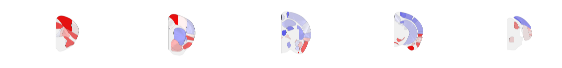

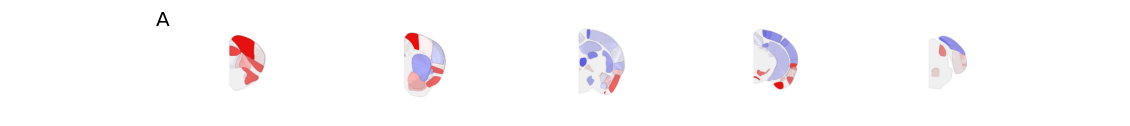

In [45]:
from pylab import *
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt

list_coor = [-2100, -1080, +1360, +2820, +4500] # Bregma corresponding coordinates
timepoint=[1,3,6]
image=[]
for tp in timepoint:
    for section in list_coor:
        Cor = Image.open("../Screenshot_Brainrender/residuals/50um_SNc_MPI1_Breg_{}_mm.png".format(-section/1000))
        image.append(Cor)
        
fig = plt.figure(figsize=(10,1))

G = gridspec.GridSpec(nrows=4, ncols=15)


axes_1_1 = fig.add_subplot(G[0:4, 0:3])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
#plt.text(3250,-100,"MPI 1", ha="right")
# plt.annotate("A",(50,150), fontsize=7, color="black")
plt.imshow(image[0])

axes_2_1 = fig.add_subplot(G[0:4, 3:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[1])

axes_3_1 = fig.add_subplot(G[0:4, 6:9])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[2])

axes_4_1 = fig.add_subplot(G[0:4, 9:12])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[3])

axes_5_1 = fig.add_subplot(G[0:4, 12:15])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[4])

plt.savefig('../Data_ReScience/residuals/vulnerability.png', dpi=300)
plt.savefig('../Data_ReScience/residuals/vulnerability.pdf', dpi=300)

vul = Image.open('../Data_ReScience/residuals/vulnerability.png')
fig = plt.figure(figsize=(20,20))
plt.annotate("A",(400,50), fontsize=20, color="black")
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(vul)

plt.savefig('../Data_ReScience/residuals/vulnerability.png', dpi=300)
plt.savefig('../Data_ReScience/residuals/vulnerability.pdf', dpi=300)
plt.show()

0.5826647387422237


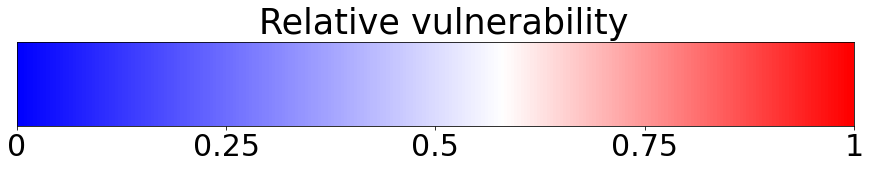

In [46]:
from matplotlib.colors import LinearSegmentedColormap

def view_colormap(cmap):
    """Plot a colormap with its grayscale equivalent"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    plt.figure(figsize=(15,3))
    plt.imshow([colors], extent=[0, 10, 0, 1])
    plt.xticks([0, 2.5, 5, 7.5 ,10], ['0', '0.25', '0.5','0.75','1'], fontsize=30)
    plt.yticks([])
    plt.text(2.9,1.1,'Relative vulnerability', fontsize=35)
    #plt.text(10.5,0.6,'Estimated percentage of area with \u03B1-synuclein')

print(mid_pt)
cmap=shiftedColorMap(cmap=plt.get_cmap("bwr"), start=0.0, midpoint=mid_pt, stop=1.0, name="ternary_centered")
view_colormap(cmap)

## b) SNCA application

In [47]:
from vedo import embedWindow
embedWindow(None)

from brainrender import Scene
import brainrender
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
os.getcwd()
reg_names = pd.read_excel('./Data83018/BrainR_ROInames.xlsx')
snca_exp = pd.read_csv('Data83018/SncaExpression.csv', header=None, )
snca_exp.head()
snca_exp.columns= ["Regions","SNCA_val"]
snca_exp.head()


for r in snca_exp.index:
    
    names = reg_names[reg_names['ROInames'] == snca_exp.loc[r, 'Regions']]['BrainR']
    
    if len(names) > 1:
         snca_exp.loc[r, 'br_regions'] = list(names)[0]
    elif len(names) == 1:    
        snca_exp.loc[r, 'br_regions'] = names.values   
        
for r in snca_exp.index:
    
    if snca_exp.loc[r, 'Regions'][0] == 'i':
        snca_exp.loc[r, 'hem'] = 'right'
    elif snca_exp.loc[r, 'Regions'][0] == 'c':
        snca_exp.loc[r, 'hem'] = 'left'
        
snca_exp= snca_exp.dropna() #Dropping the br_regions overlapping in brain render
max_val= np.max(snca_exp["SNCA_val"].values)
min_val= np.min(snca_exp["SNCA_val"].values)

#no need for midpoint as continous
cmap=plt.get_cmap("YlOrRd")
#normalisation
snca_exp["SNCA_val"]=(snca_exp["SNCA_val"] - min_val)/(max_val-min_val)
snca_exp

,Regions,SNCA_val,br_regions,hem
0,iM2,0.985962,MOs,right
1,iM1,0.703961,MOp,right
2,iAI,0.725033,AId,right
3,iPrL,0.868442,PL,right
4,iMO,0.636978,ORBm,right
...,...,...,...,...
110,cEnt,0.985708,ENT,left
111,cPS,0.366010,SUB,left
113,cSuC,0.106475,SCs,left
114,cIC,0.105516,IC,left


In [48]:
# Saving BrainRender SNCA expression
list_coor = [-2100, -1080, +1360, +2820, +4500] # Bregma corresponding coordinates
timepoints = [1,3,6]
for section in tqdm(list_coor):
    bregma = np.array([5400,  # AP    
          0,  # DV    
          5700,]) # ML

    bregma[0] = bregma[0] + section

    # Create a brainrender scene
    scene = Scene(inset=False,screenshots_folder="../Screenshot_Brainrender/SNCA_exp")
    frontal_camera = {
         'pos': (-19781, 3777, -5832),
         'viewup': (0, -1, 0),
         'clippingRange': (26465, 26836),
        'focalPoint': (5705, 3991, -5691),
         'distance': 25487}

   # Add brain regions
    for r in snca_exp.index:

        region_to_plot = snca_exp.loc[r, "br_regions"]
        color = cmap(snca_exp.loc[r, 'SNCA_val'])[:3]

        scene.add_brain_region(region_to_plot, color=color, alpha=1, hemisphere=snca_exp.loc[r, 'hem'], silhouette=True) #alpha=snca_exp.loc[r, 'SNCA_val'])


    plane_1 = scene.atlas.get_plane(pos=bregma+50, plane="frontal", norm=(-1, 0, 0), alpha=1, color="white") # Thickness: 150 um
    plane_2 = scene.atlas.get_plane(pos=bregma-50, plane="frontal", norm=(1, 0, 0), alpha=1, color="white")
    plane_3 = scene.atlas.get_plane(plane="sagittal", norm=(0,0,-1), alpha=1, color="white")
    scene.slice(plane_1, close_actors=True)
    scene.slice(plane_2, close_actors=True)
    scene.slice(plane_3, close_actors=True)


    brainrender.settings.SHADER_STYLE = "cartoon" #[metallic, plastic, shiny, glossy]
    brainrender.settings.ROOT_ALPHA = 0.17
    brainrender.settings.LW = 2.4
    brainrender.settings.ROOT_COLOR  = [0.4, 0.4, 0.4]
    brainrender.settings.OFFSCREEN = True
    brainrender.settings.SHOW_AXES = False
    brainrender.settings.BACKGROUND_COLOR = "white"
    scene.render(atlas_name='allen_mouse_50um', camera= frontal_camera, zoom=1.5)
    scene.screenshot(name="SNCA_exp_Breg{}.png".format(-section/1000), scale = 3)
    img_totranspose = Image.open("../Screenshot_Brainrender/SNCA_exp/SNCA_exp_Breg{}.png".format(-section/1000))
    img_totranspose = img_totranspose.transpose(Image.FLIP_LEFT_RIGHT)
    img_totranspose.save("../Screenshot_Brainrender/SNCA_exp/SNCA_exp_Breg{}.png".format(-section/1000))
    #title="-Coronal section Bregma {} mm -50um thickness- Seed = SN - MPI {}".format(-section/1000,t),
    scene.close()

  0%|          | 0/5 [00:00<?, ?it/s]

Saving new screenshot at SNCA_exp_Breg2. 1. png

 20%|██        | 1/5 [00:16<01:04, 16.09s/it]

Saving new screenshot at SNCA_exp_Breg1. 08. png

 40%|████      | 2/5 [00:32<00:48, 16.05s/it]

Saving new screenshot at SNCA_exp_Breg- 1.36 .png

 60%|██████    | 3/5 [00:48<00:32, 16.26s/it]

Saving new screenshot at SNCA_exp_Breg- 2.82 .png

 80%|████████  | 4/5 [01:07<00:16, 16.90s/it]

Saving new screenshot at SNCA_exp_Breg- 4.5 .png

100%|██████████| 5/5 [01:30<00:00, 18.03s/it]


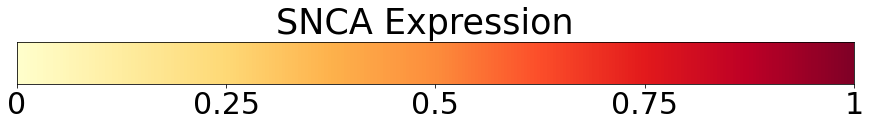

In [49]:
from matplotlib.colors import LinearSegmentedColormap

def view_colormap(cmap):
    """Plot a colormap with its grayscale equivalent"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    plt.figure(figsize=(15,3))
    plt.imshow([colors], extent=[0, 10, 0, 0.5])
    plt.xticks([0, 2.5, 5, 7.5 ,10], ["0", '0.25', '0.5','0.75','1'],fontsize=30)
    plt.yticks([])
    plt.text(3.1,0.6,'SNCA Expression',fontsize=35)
    #plt.text(10.5,0.6,'Estimated percentage of area with \u03B1-synuclein')
    plt.savefig('../Screenshot_Brainrender/SNCA_exp/scale.png', dpi=300)
    plt.savefig('../Screenshot_Brainrender/SNCA_exp/scale.pdf', dpi=300)
      
view_colormap("YlOrRd")

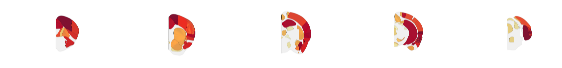

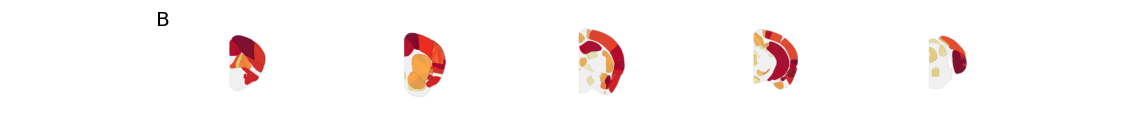

In [50]:
from pylab import *
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt

list_coor = [-2100, -1080, +1360, +2820, +4500] # Bregma corresponding coordinates
timepoint=[1,3,6]
image=[]
for tp in timepoint:
    for section in list_coor:
        Cor = Image.open("../Screenshot_Brainrender/SNCA_exp/SNCA_exp_Breg{}.png".format(-section/1000))
        image.append(Cor)
        
fig = plt.figure(figsize=(10,1))

G = gridspec.GridSpec(nrows=4, ncols=15)


axes_1_1 = fig.add_subplot(G[0:4, 0:3])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
#plt.text(3250,-100,"MPI 1", ha="right")
# plt.annotate("A",(50,150), fontsize=7, color="black")
plt.imshow(image[0])

axes_2_1 = fig.add_subplot(G[0:4, 3:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[1])

axes_3_1 = fig.add_subplot(G[0:4, 6:9])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[2])

axes_4_1 = fig.add_subplot(G[0:4, 9:12])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[3])

axes_5_1 = fig.add_subplot(G[0:4, 12:15])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[4])

plt.savefig('../Data_ReScience/SNCA_exp/SNCA_exp_summary.png', dpi=300)
plt.savefig('../Data_ReScience/SNCA_exp/SNCA_exp_summary.pdf', dpi=300)

vul = Image.open('../Data_ReScience/SNCA_exp/SNCA_exp_summary.png')
fig = plt.figure(figsize=(20,20))
plt.annotate("B",(400,50), fontsize=20, color="black")
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(vul)

plt.savefig('../Data_ReScience/SNCA_exp/SNCA_exp_summary.png', dpi=300)
plt.savefig('../Data_ReScience/SNCA_exp/SNCA_exp_summary.pdf', dpi=300)
plt.show()